In [1]:
import pickle
import sys
sys.path.append('../../')
from inverse_kinematics import InverseKinematicsModel
import matplotlib.pyplot as plt
from c2st import c2st
import bayesflow as bf


/Users/marvin/miniforge3/envs/cmpe/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
simulation_budgets = [512, 1024, 2048, 4096, 8192]
tasks = ['gmm', 'twomoons', 'invkinematics']
task_names = {'gmm': 'GMM', 'twomoons': 'Two Moons', 'invkinematics': 'Kinematics'}

estimators = ['acf', 'nsf', 'cmpe', 'fmpe']

eval_dict = pickle.load(open('computations/eval_dict.pkl', 'rb'))

reference_posteriors = {
        'gmm': pickle.load(open('./data/gmm_reference_posterior_samples.pkl', 'rb')),
        'twomoons': pickle.load(open('./data/twomoons_reference_posterior_samples.pkl', 'rb')),
        'invkinematics': pickle.load(open('./data/invkinematics_reference_posterior_samples.pkl', 'rb')),
    }


In [3]:
reference_posteriors['gmm'].shape

(100, 4000, 2)

In [4]:
colors = ['#440154', '#3b528b', '#21908dff', '#5dc962ff', '#fde725ff', '#fde725ff', '#fde725ff']
plot_settings = {
    'ac': {'name': 'ACF', 'color': colors[0]},
    'nsf': {'name': 'NSF', 'color': colors[1]},
    'fmpe10': {'name': 'FMPE 10#', 'color': colors[3]},
    'fmpe30': {'name': 'FMPE 30#', 'color': colors[4]},
    'fmpe': {'name': 'FMPE 1000#', 'color': colors[2]},
    'cmpe10': {'name': 'CMPE 10#', 'color': colors[5]},
    'cmpe30': {'name': 'CMPE 30#', 'color': colors[6]},
}

In [7]:
def plot(ax, reference, approximate, task, reference_color=(0.8, 0.4, 0.4), approximate_color=(1, 1, 1), **kwargs):
    if task == 'twomoons' or task == 'gmm':
        if reference is not None:
            ax.scatter(reference[:, 0], reference[:, 1], color=reference_color, **kwargs)
        if approximate is not None:
            ax.scatter(approximate[:, 0], approximate[:, 1], color=approximate_color, **kwargs)
    elif task == 'invkinematics':
        pass
        if approximate is not None:
            if reference_color == (0.8, 0.4, 0.4):
                linecolors = [(1,1,1), (0.8, 0.8, 0.8), (0.7, 0.7, 0.7)]
            else:
                linecolors = [(0.8, 0.4, 0.4)] * 3
            m = InverseKinematicsModel(linecolors=linecolors)
            m.update_plot_ax(ax, approximate, reference)#, target_label=r'$\theta^*$')
    else:
        raise ValueError(f'Unknown task {task}')

    if task == 'twomoons':
        ax.set_xlim([-0.5, 0.5])
        ax.set_ylim([-0.5, 0.5])
    elif task == 'gmm':
        gmm_limit = 2.5
        ax.set_xlim([-gmm_limit, gmm_limit])
        ax.set_ylim([-gmm_limit, gmm_limit])

    return ax

In [8]:
def plot_grid(idx=0, budget=1024):
    nrows = len(tasks)
    ncols = len(plot_settings) + 1

    scatter_kws = {
        "alpha": 0.20,
        "rasterized": True,
        "s": 0.7,
        "marker": "D",
    }

    f, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4), subplot_kw=dict(box_aspect=1), squeeze=False)


    for i, task in enumerate(tasks):
        axes[i, 0].set_ylabel(task_names[task], rotation=90, size='xx-large')

        # # Plot Reference
        # if task == 'invkinematics':
        #     axes[i, 0] = plot(axes[i, 0], reference_posteriors[task], inverse_kinematics_abc, task, reference_color='custom', **scatter_kws)
        # else:
        #     axes[i, 0] = plot(axes[i, 0], reference_posteriors[task], None, task, **scatter_kws)

        # Plot Approximate
        for j, estimator in enumerate(plot_settings.keys(), 1):
            if i == 0:
                axes[i, j].set_title(plot_settings[estimator]['name'], size='xx-large')
            posterior_samples = eval_dict[task][budget][estimator]['posterior_samples'][idx]
            reference_samples = reference_posteriors[task][idx]
            axes[i, j] = plot(axes[i, j], reference_samples, posterior_samples, task, **scatter_kws)

            c2st_value = c2st(posterior_samples, reference_samples)
            mmd=bf.computational_utilities.maximum_mean_discrepancy(posterior_samples, reference_samples)

            axes[i, j].set_title(f'mmd:{mmd:.3f}, c2st:{c2st_value:.3f}')

    axes[0, 0].set_title("Reference", size='xx-large')

    for ax in axes.flat:
        ax.grid(False)
        ax.set_facecolor((0 / 255, 32 / 255, 64 / 255, 1.0))
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.spines["bottom"].set_alpha(0.0)
        ax.spines["top"].set_alpha(0.0)
        ax.spines["right"].set_alpha(0.0)
        ax.spines["left"].set_alpha(0.0)
        ax.set_aspect('equal')

    f.tight_layout()

    # f.savefig('./figures/benchmark_showcase.pdf', dpi=300, bbox_inches='tight')

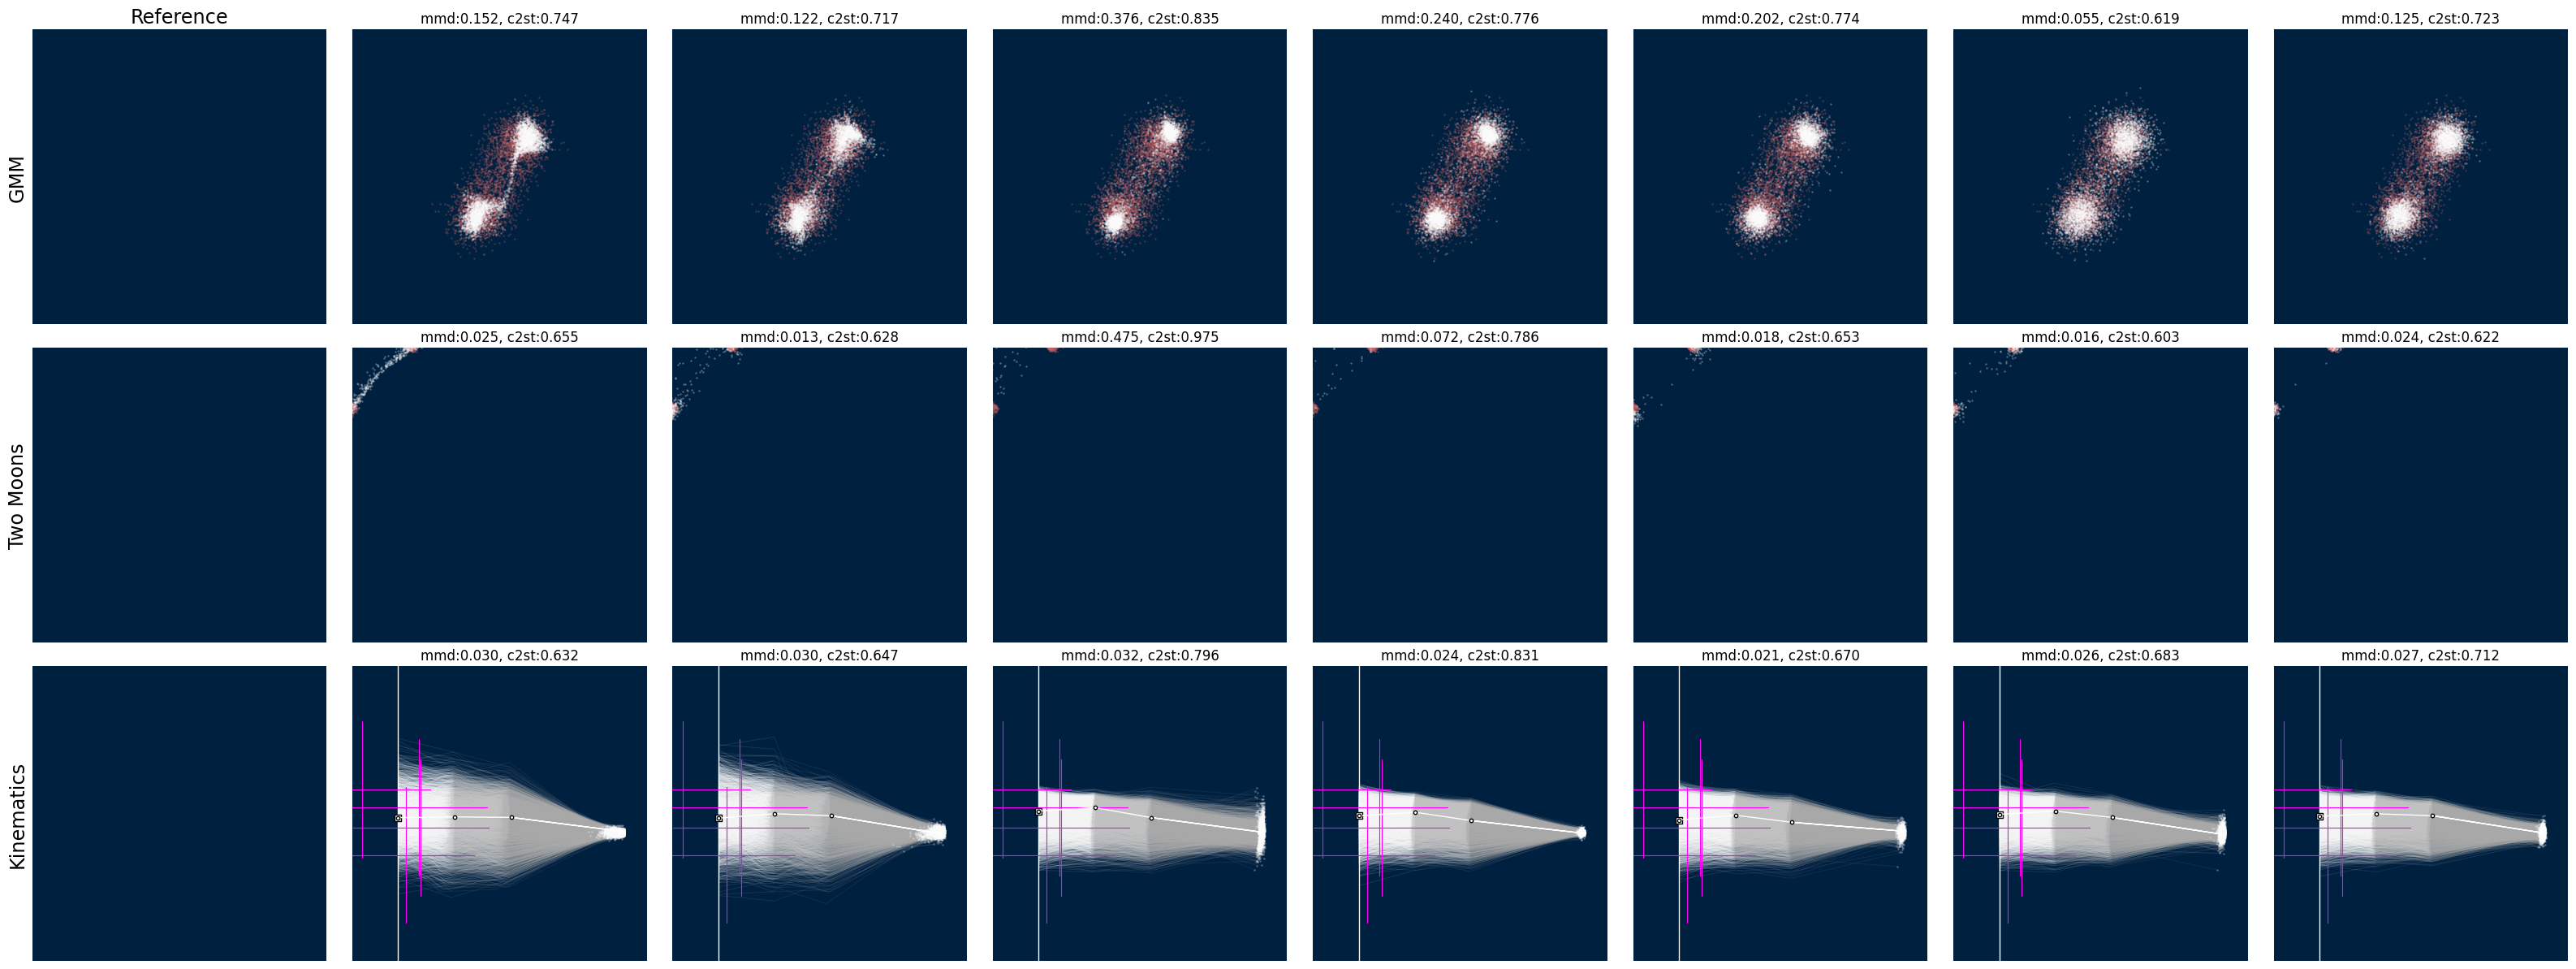

In [9]:
plot_grid(idx=0, budget=1024)